In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from hog_extractor import extract_hog_features
from lbp_extractor import extract_lbp_features
from cnn_extractor import load_pretrained_model, extract_cnn_features
import pickle

c:\Users\varchasva\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Importing Dataset


Face Detection and Cropping (For Avoiding Background Noise)

In [45]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'VGG2_Dataset'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)

KeyboardInterrupt: 

Loading Dataset from Pickle

In [18]:
# Path to pickle file

pickle_file = 'cropped_faces.pkl'

# Check if pickle file exists
if os.path.exists(pickle_file):
    # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        images, labels = pickle.load(f)
    print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons from pickle file.")
else:
    # Load dataset with face detection and save to pickle file
    images, labels = load_dataset_with_face_detection(dataset_path)
    with open(pickle_file, 'wb') as f:
        pickle.dump((images, labels), f)
    print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons and saved to pickle file.")

Loaded 13550 cropped face images for 50 persons from pickle file.


In [ ]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[ 10  29  79]
  [ 16  32  79]
  [ 26  38  81]
  ...
  [225 223 226]
  [241 240 242]
  [245 245 245]]

 [[ 10  30  81]
  [ 24  40  87]
  [ 19  29  73]
  ...
  [213 212 215]
  [227 226 228]
  [229 229 229]]

 [[ 24  40  82]
  [ 20  33  78]
  [ 16  26  73]
  ...
  [205 205 212]
  [217 215 218]
  [224 219 219]]

 ...

 [[ 22  26  55]
  [ 20  22  46]
  [ 16  15  35]
  ...
  [242 242 242]
  [241 241 241]
  [244 242 242]]

 [[  7  12  40]
  [ 20  23  47]
  [ 23  22  41]
  ...
  [239 239 239]
  [240 240 240]
  [247 245 245]]

 [[ 14  16  39]
  [ 22  23  45]
  [ 16  17  37]
  ...
  [235 234 238]
  [242 241 245]
  [248 245 247]]]
[[[ 25  49 149]
  [ 13  36 137]
  [ 21  43 145]
  ...
  [120 169 159]
  [113 163 149]
  [117 167 149]]

 [[ 28  50 150]
  [  2  25 125]
  [ 22  45 146]
  ...
  [121 172 165]
  [112 165 152]
  [109 162 145]]

 [[ 20  39 137]
  [  9  33 128]
  [ 30  55 149]
  ...
  [127 176 175]
  [112 166 156]
  [106 161 143]]

 ...

 [[ 10  29 108]
  [ 22  39 119]
  [ 17

Extracting features from all images

In [3]:
from cnn_extractor import load_pretrained_model, extract_cnn_features

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model= load_pretrained_model().to(device)  # Load model to device

c:\Users\varchasva\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def extract_all_features(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        # pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        cnn_feat = extract_cnn_features(img, model, device)
        
        # Concatenate all features into one vector
        # combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])

        
        # Without pixel features
        combined = np.concatenate([cnn_feat,hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [8]:
all_features=extract_all_features(images)
print("Features shape:", all_features.shape)

Features shape: (13550, 8622)


In [22]:
import pickle

# Path to save the pickle file
features_pickle_file = 'saved_models/all_features.pkl'

# Save all_features to a pickle file
with open(features_pickle_file, 'wb') as f:
    pickle.dump(all_features, f)

print(f"Features saved to {features_pickle_file}")

Features saved to saved_models/all_features.pkl


In [23]:
# Load all_features from the pickle file
with open(features_pickle_file, 'rb') as f:
    all_features = pickle.load(f)

print(f"Features loaded from {features_pickle_file}")

Features loaded from saved_models/all_features.pkl


Creating Dataframe 

In [10]:
import pandas as pd

df = pd.DataFrame(all_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(all_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (13550, 8623)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.801774   0.289568   0.128639   0.000000   0.238697   0.237671   
1   1.115273   0.469786   0.052365   0.104667   0.184061   0.382347   
2   1.275164   0.208560   0.306294   0.013594   0.324218   0.243020   
3   0.807836   0.954175   0.029728   0.221532   0.053548   0.001983   
4   1.678363   0.082128   0.103294   0.235627   0.131299   0.028882   

   feature_6  feature_7  feature_8  feature_9  ...  feature_8613  \
0   0.132570   0.250138   0.482535   0.347198  ...      0.057983   
1   0.333091   0.204930   0.544833   0.599637  ...      0.051758   
2   0.312936   0.119114   0.833818   0.339841  ...      0.088074   
3   0.216126   0.132934   0.171221   0.491760  ...      0.042786   
4   0.762227   0.256464   0.166599   1.114581  ...      0.031067   

   feature_8614  feature_8615  feature_8616  feature_8617  feature_8618  \
0      0.047729      0.135986      0.299744      0.156860 

Label Encoding

In [24]:
from sklearn.model_selection import train_test_split
import joblib
# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y contains names of persons

df['label'] = y_encoded  # Update the DataFrame with encoded labels
y= df['label']  # Use the encoded labels for y
joblib.dump(label_encoder, "saved_models/label_encoder.pkl")

['saved_models/label_encoder.pkl']

In [12]:
print(df['label'].unique())  # Check unique labels
print(y_encoded)  # Check encoded labels

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  0  0 ... 49 49 49]


Applying Standard Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # X is your feature matrix

In [25]:
joblib.dump(scaler, "saved_models/scalar.pkl")

['saved_models/scalar.pkl']

In [14]:
print("Normalized features shape:", X_normalized.shape)

Normalized features shape: (13550, 8622)


Applying PCA to reduce dimensionality

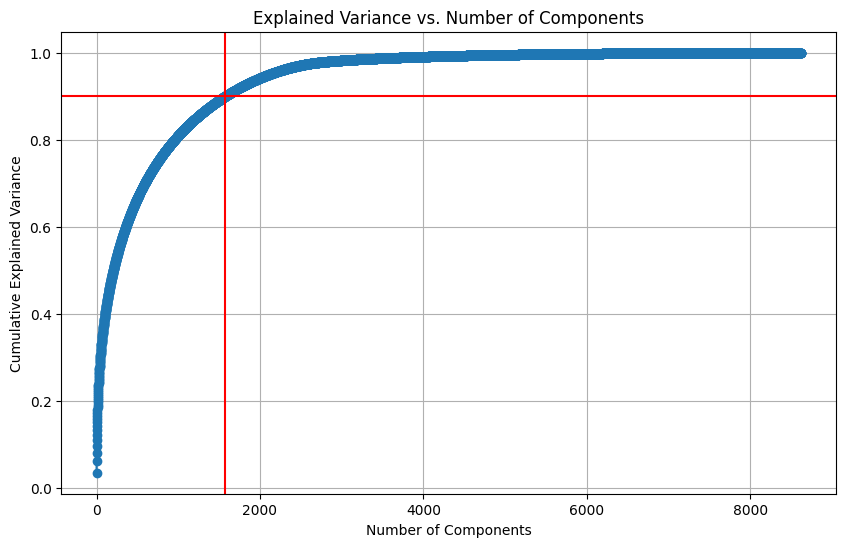

Optimal number of components for 90% variance: 1575


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Fit PCA on the data
pca = PCA().fit(X_normalized)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.90, color='r', linestyle='-')  # For example, 90% threshold
plt.axvline(x=np.argmax(cumulative_variance >= 0.90), color='r', linestyle='-')
plt.grid(True)
plt.show()

# Determine the optimal number of components for a 90% threshold
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Optimal number of components for 90% variance: {optimal_components}")

In [ ]:
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=optimal_components)  # Adjust based on variance plot
X_pca = pca_1.fit_transform(X_normalized)

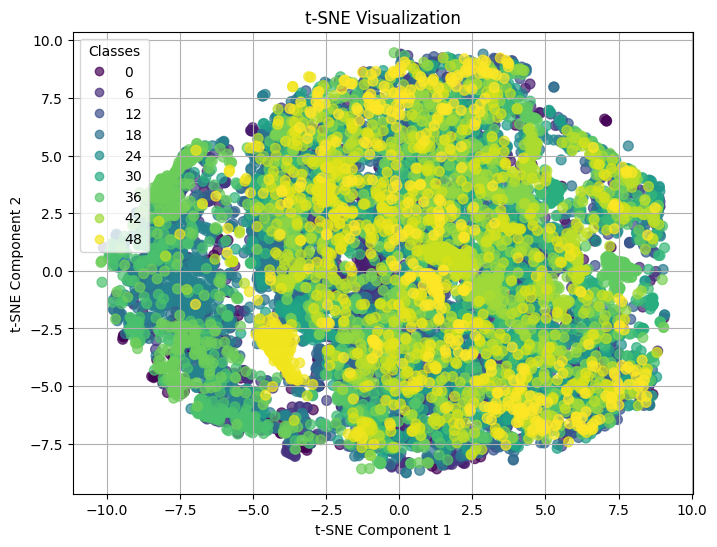

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Visualize the t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust based on variance plot
X_pca = pca.fit_transform(X_normalized)

joblib.dump(pca, "saved_models/pca_model.pkl")

['saved_models/pca_model.pkl']

In [ ]:
# # For finding the optimal number of components
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np
# # Fit PCA to the normalized data
# pca = PCA().fit(X_normalized)
# # Plot the explained variance ratio for each principal component
# plt.figure(figsize=(10, 6))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('PCA Explained Variance')
# plt.grid()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
# plt.title('PCA Explained Variance Ratio')
# plt.xlabel('Principal Component Index')
# plt.ylabel('Explained Variance Ratio')
# plt.grid()
# plt.show()

In [ ]:
pca = PCA(n_components=0.90)  # Retains 90% of the variance
X_pca = pca.fit_transform(X_normalized)
print("Number of selected components:", pca.n_components_)

Number of selected components: 1575


Train-Test Split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (10840, 100), Test set size: (2710, 100)


In [18]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10840, 100)
X_test shape: (2710, 100)
y_train shape: (10840,)
y_test shape: (2710,)


Convert to Pytorch Tensors

In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


Applying ML Model


1. Decision Tree

Decision Tree Accuracy: 0.1911
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.04      0.05        57
           1       0.00      0.00      0.00        31
           2       0.23      0.27      0.25        82
           3       0.20      0.05      0.08        19
           4       0.18      0.23      0.21        81
           5       0.10      0.09      0.09        46
           6       0.04      0.02      0.03        42
           7       0.08      0.04      0.05        25
           8       0.23      0.37      0.28        67
           9       0.12      0.04      0.06        75
          10       0.13      0.15      0.14        39
          11       0.10      0.19      0.13        47
          12       0.16      0.09      0.12        32
          13       0.12      0.27      0.16        82
          14       0.10      0.02      0.03        48
          15       0.15      0.21      0.17        48
          16       0.44   

c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

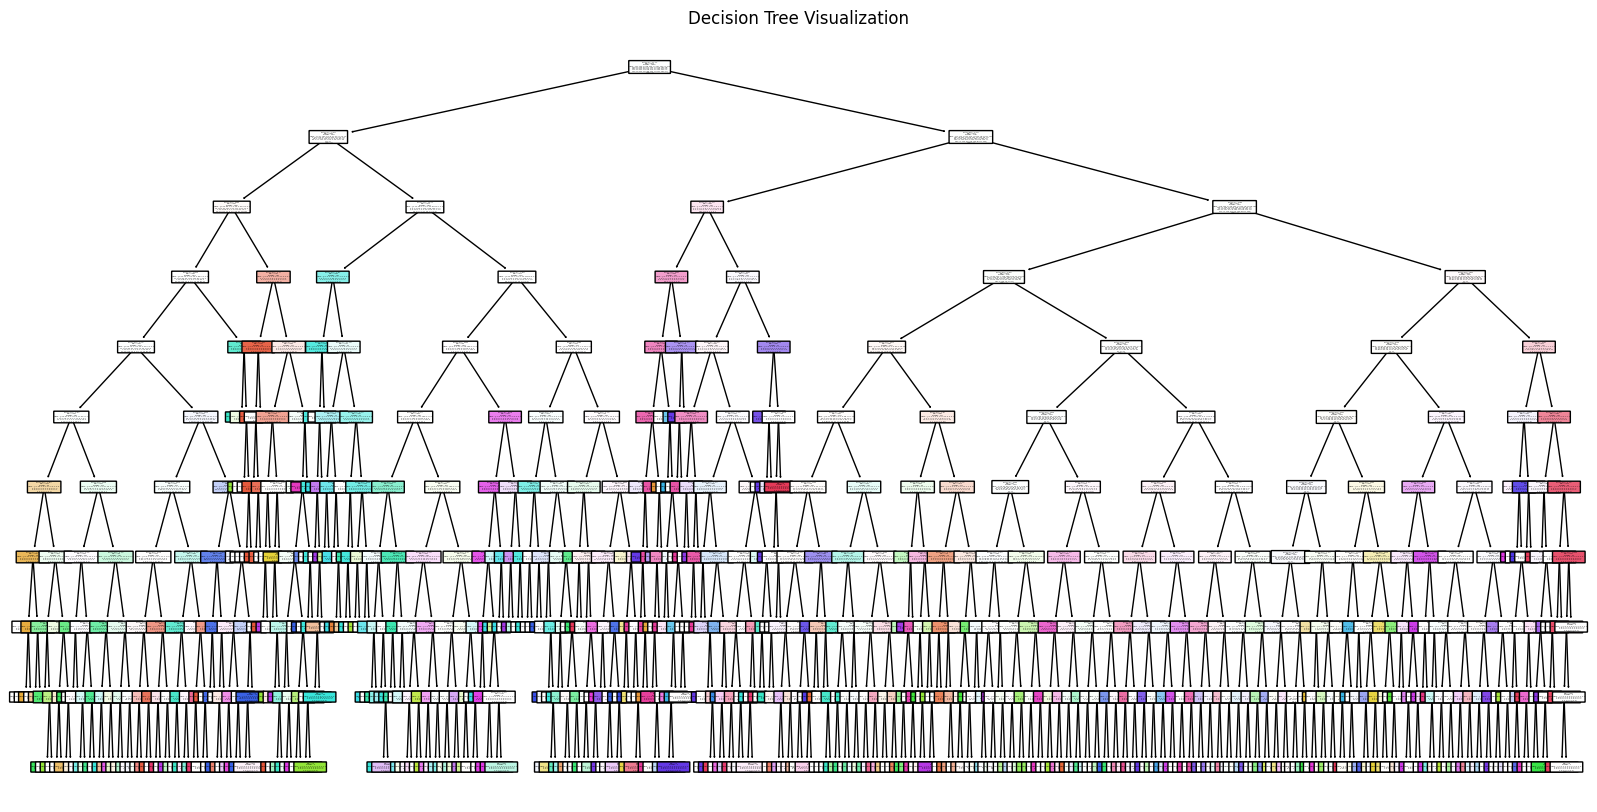

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define optimal hyperparameters
optimal_params = {
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

# Initialize and train the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42, **optimal_params)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Decision Tree Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=[f'Feature {i}' for i in range(X_train.shape[1])], 
          class_names=[str(c) for c in set(y_train)], rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


Visualizing results


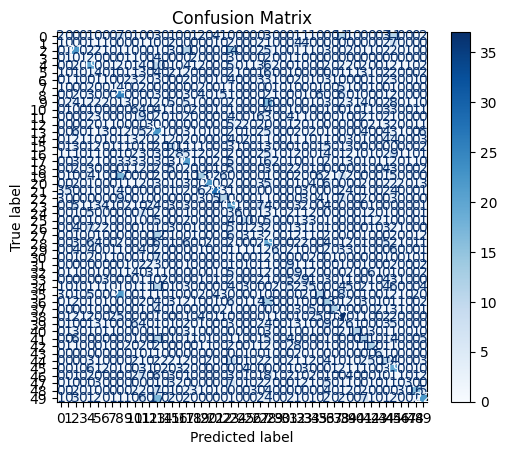

C:\Users\Atanu Kayal\AppData\Local\Temp\ipykernel_22088\2226196110.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


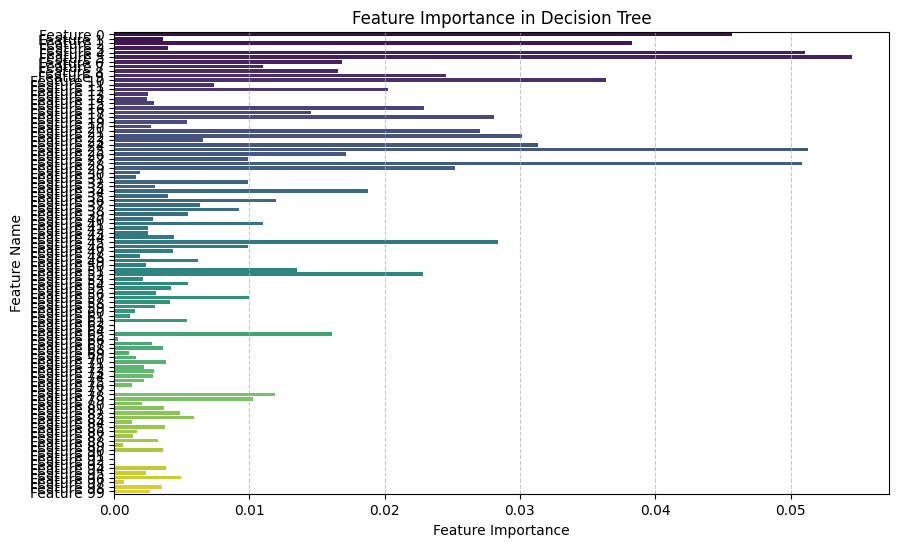

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance Plot
feature_importances = clf.feature_importances_
feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Decision Tree")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


rf_original = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_leaf=2,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

rf_original.fit(X_train, y_train)
y_pred = rf_original.predict(X_test)
rf_accuracy = rf_original.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.5720

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.21      0.31        57
           1       0.67      0.26      0.37        31
           2       0.62      0.71      0.66        82
           3       0.80      0.21      0.33        19
           4       0.46      0.75      0.57        81
           5       0.87      0.57      0.68        46
           6       0.57      0.29      0.38        42
           7       0.81      0.52      0.63        25
           8       0.56      0.75      0.64        67
           9       0.63      0.45      0.53        75
          10       0.50      0.69      0.58        39
          11       0.95      0.45      0.61        47
          12       0.86      0.38      0.52        32
          13       0.37      0.61      0.46        82
          14       0.00      0.00      0.00        48
          15       0.62      0.38      0.47        48
          16       0.65   

Visualize results


C:\Users\Atanu Kayal\AppData\Local\Temp\ipykernel_22088\1070092231.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


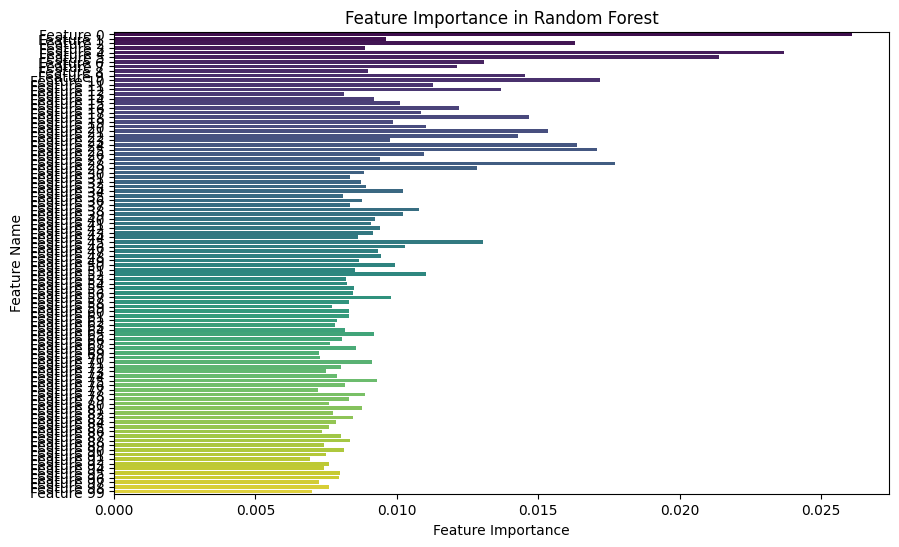

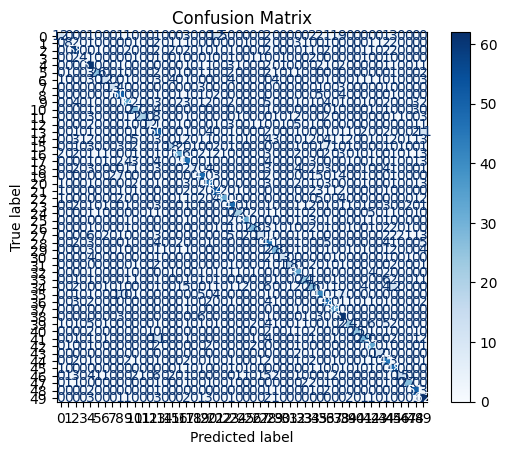

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 1. Feature Importance Plot
feature_importances = rf_original.feature_importances_
feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest")
plt.show()

# 2. Confusion Matrix
y_pred = rf_original.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Finding best hyperparameters


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import numpy as np
# import time

# # Assuming X_train, X_test, y_train, y_test are already defined

# # Split the dataset if needed
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Define parameter grid for Random Forest tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Increase trees
#     'max_depth': [None, 20, 30],  # Allow deeper trees
#     'min_samples_split': [2, 5, 10],  # Control splitting
#     'min_samples_leaf': [1, 2, 4],  # Control leaf size
#     'bootstrap': [True, False]  # Try bootstrapping
# }

# # Initialize the Random Forest Classifier
# rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# # Hyperparameter tuning using GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# # Train the model
# start_time = time.time()
# grid_search.fit(X_train, y_train)
# train_time = time.time() - start_time

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# # Train final model with best parameters
# best_rf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
# best_rf.fit(X_train, y_train)

# # Predictions
# y_pred = best_rf.predict(X_test)

# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")
# print(f"Training time: {train_time:.2f} seconds")

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion matrix
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# # Cross-validation accuracy
# cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
# print(f"\nCross-validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


3.  KNN - K-Nearest Neighbors


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=12, weights='uniform', metric='euclidean')

# Train the KNN model
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

KNN Accuracy: 0.5801

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.47      0.57        57
           1       0.29      0.48      0.37        31
           2       0.48      0.73      0.58        82
           3       0.50      0.21      0.30        19
           4       0.64      0.73      0.68        81
           5       0.63      0.74      0.68        46
           6       0.36      0.38      0.37        42
           7       0.50      0.64      0.56        25
           8       0.56      0.67      0.61        67
           9       0.46      0.41      0.44        75
          10       0.43      0.74      0.54        39
          11       0.53      0.66      0.59        47
          12       0.57      0.66      0.61        32
          13       0.37      0.56      0.44        82
          14       0.27      0.21      0.24        48
          15       0.40      0.35      0.38        48
          16       0.66      0.44   

VISUALISATION PLOTS FOR KNN

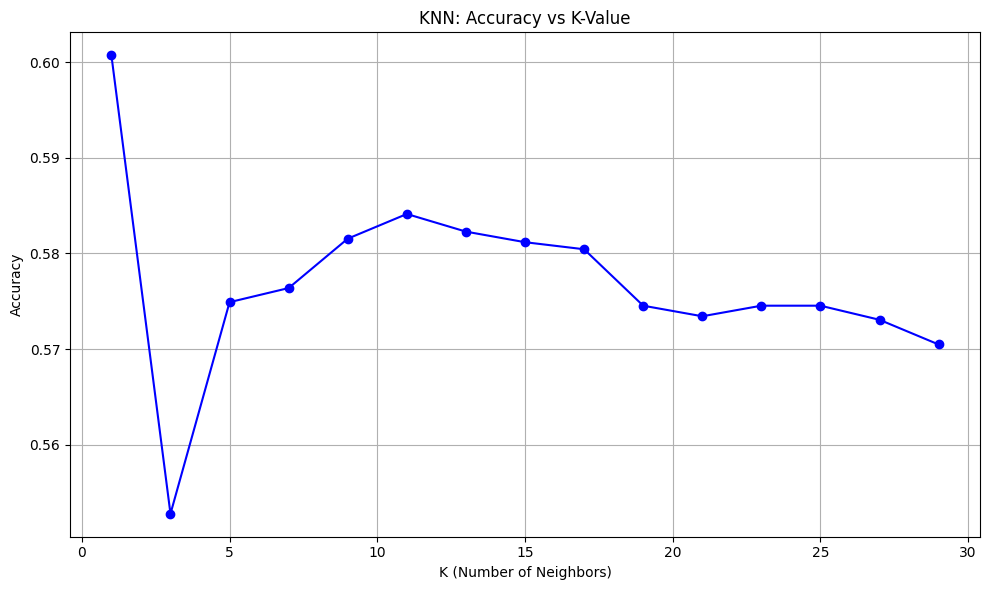

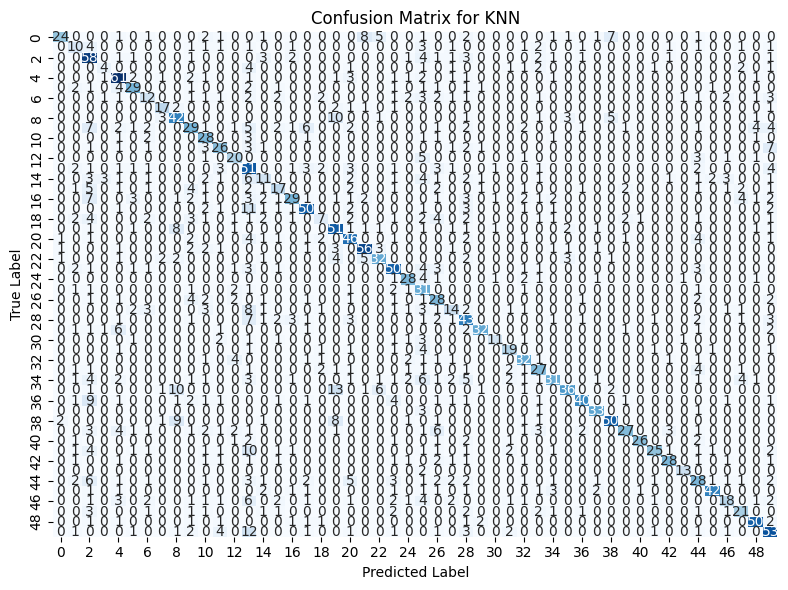

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# 1. K-value optimization plot
k_range = range(1, 31, 2)
k_scores = []

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    y_pred = knn_model.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    k_scores.append(accuracy)
    # scores = cross_val_score(knn_model, X_train, y_train, cv=5)
    # k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='-', color='blue')
plt.title('KNN: Accuracy vs K-Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN')
plt.tight_layout()
plt.show()

# 3. Feature importance using permutation importance
# result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
# feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(X_train.shape[1])]
# sorted_idx = result.importances_mean.argsort()

# plt.figure(figsize=(10, 8))
# plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
# plt.title('KNN Feature Importance')
# plt.xlabel('Mean Decrease in Accuracy')
# plt.tight_layout()
# plt.show()

Hyperparameter Tuning

In [ ]:
# # Hyperparameter tuning for KNN
# print("\nPerforming hyperparameter tuning for KNN...")
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'minkowski'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
# }

# grid_search = GridSearchCV(
#     KNeighborsClassifier(),
#     param_grid,
#     cv=3,
#     scoring='accuracy',
#     n_jobs=-1
# )

# start_time = time.time()
# grid_search.fit(X_train, y_train)
# tuning_time = time.time() - start_time

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"GridSearchCV took {tuning_time:.2f} seconds")


# # Visualize accuracy vs k value
# k_values = list(range(1, 21))
# accuracies = []

# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k, **{key: value for key, value in grid_search.best_params_.items() if key != 'n_neighbors'})
#     knn.fit(X_train, y_train)
#     y_pred = knn.predict(X_test)
#     accuracies.append(accuracy_score(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# plt.plot(k_values, accuracies, marker='o', linestyle='-', color='#3498db')
# plt.title('KNN Accuracy vs k Value')
# plt.xlabel('k (Number of Neighbors)')
# plt.ylabel('Accuracy')
# plt.xticks(k_values)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# print(f"Best KNN accuracy: {grid_search.best_score_:.4f}")

  4.    Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
joblib.dump(svm, "saved_models/svm_model.pkl")
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


SVM Accuracy: 0.7601476014760148

Classification Report:


NameError: name 'classification_report' is not defined

SVM with different Kernels

SVM with linear kernel Accuracy: 0.6376
SVM with poly kernel Accuracy: 0.6989
SVM with rbf kernel Accuracy: 0.7568
SVM with sigmoid kernel Accuracy: 0.6428


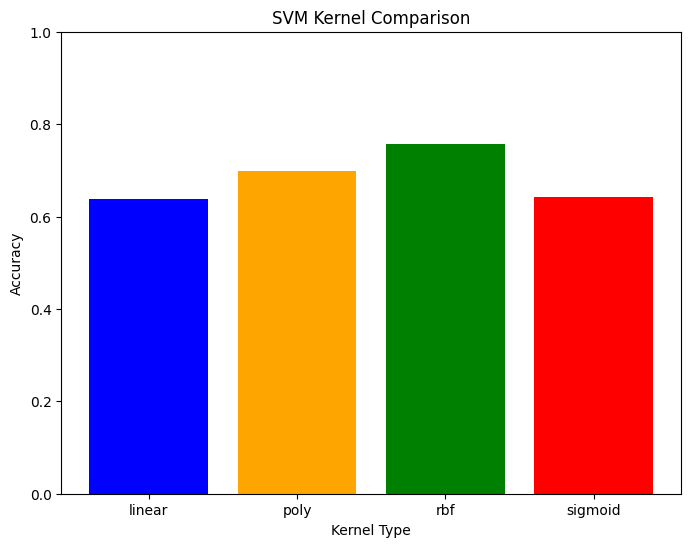

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define different kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_accuracies = {}

# Iterate over kernels and fit SVM
for kernel in kernels:
    svm = SVC(kernel=kernel, C=1.0, gamma='scale' , random_state=42)
    svm.fit(X_train, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    kernel_accuracies[kernel] = acc
    print(f"SVM with {kernel} kernel Accuracy: {acc:.4f}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(kernel_accuracies.keys(), kernel_accuracies.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy')
plt.title('SVM Kernel Comparison')
plt.ylim(0, 1)
plt.show()

Randomly generating Image for Prediction

In [23]:
# Load the saved PCA and StandardScaler objects
pca = joblib.load("pca_model.pkl")  # PCA object saved during training
scaler = joblib.load("scalar.pkl")  # Scaler object saved during training
svm = joblib.load("svm_model.pkl")  # SVM model saved during training
# Load the trained SVM model
#svm = joblib.load("svm_model.pkl")

# Randomly select an image from the dataset
random_index = np.random.randint(0, len(images))
random_image = images[random_index]
random_label = labels[random_index]

# Extract features
hog_features = extract_hog_features(random_image)
lbp_features = extract_lbp_features(random_image)
cnn_features = extract_cnn_features(random_image, model, device)

# Concatenate features
combined_features = np.concatenate([hog_features, lbp_features, cnn_features])

# Apply Standard Scaling using the loaded scaler
scaled_features = scaler.transform(combined_features.reshape(1, -1))  # Use transform, not fit_transform

# Transform features using the loaded PCA
pca_features = pca.transform(scaled_features)

# Predict the label using the trained SVM model
predicted_label = svm.predict(pca_features)[0]

# Convert the predicted label back to the original label
original_label = label_encoder.inverse_transform([predicted_label])[0]

# Output the result
print(f"Actual Label: {random_label}")
print(f"Predicted Label: {original_label}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (672x224 and 2000x64)

Real-time Face Identification using CV2

In [ ]:
from torchvision import transforms

pca = joblib.load("pca_model.pkl")  # PCA object saved during training
scaler = joblib.load("scalar.pkl")
svm

# Load face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Start capturing from the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to access the camera.")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        if face_roi.shape[0] > 0 and face_roi.shape[1] > 0 and face_roi.shape[2] == 3:
            face_resized = cv2.resize(face_roi, (128, 128))
            hog_features = extract_hog_features(face_resized)
            lbp_features = extract_lbp_features(face_resized)
            cnn_features = extract_cnn_features(face_resized, model, device)

            # Concatenate features
            combined_features = np.concatenate([hog_features, lbp_features, cnn_features])
            # Apply Standard Scaling using the loaded scaler
            scaled_features = scaler.transform(combined_features.reshape(1, -1))  # Use transform, not fit_transform

            # Transform features using the loaded PCA
            pca_features = pca.transform(scaled_features)

            # Predict the label using the trained SVM model
            predicted_label = svm.predict(pca_features)[0]

            # Convert the predicted label back to the original label
            predicted_name = label_encoder.inverse_transform([predicted_label])[0]
                        # Extract features and predict identity
            
            # Draw bounding box and name
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, predicted_name, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("Face Recognition", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\varchasva\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

KeyboardInterrupt: 

Visualization of results


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

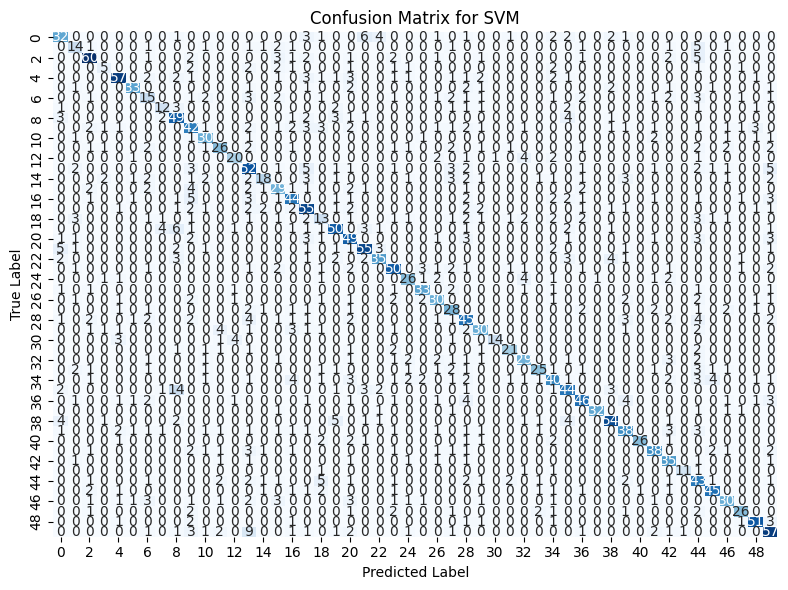

In [28]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.tight_layout()
plt.show()

Decision Boundary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_decision_boundary(X, y, model, title="SVM Decision Boundary"):
    # Reduce to 2D if necessary
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Example usage
# Fit PCA on the training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Fit and transform training data
X_test_pca = pca.transform(X_test)        # Transform test data using the same PCA object

# Train the SVM model on the PCA-transformed training data
svm_new = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_new.fit(X_train_pca, y_train)

# Plot the decision boundary using the test data
plot_decision_boundary(X_test_pca, y_test, svm_new, title="SVM Decision Boundary")

Support Vectors

In [ ]:
def plot_support_vectors(X, y, model, title="SVM Support Vectors"):
    # Reduce to 2D if necessary
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    
    # Plot data points
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.6)
    
    # Highlight support vectors
    support_vectors = model.support_vectors_
    if X.shape[1] > 2:
        support_vectors = pca.transform(support_vectors)
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', label="Support Vectors")
    
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Example usage
X_new= np.array(X_train)
y_new= np.array(y_train)
X_new_pca = PCA(n_components=2).fit_transform(X_new)  # Reduce to 2D for visualization
svm_new= SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_new.fit(X_new_pca, y_new)

plot_support_vectors(X_new_pca , y_new, svm_new, title="SVM Support Vectors")

5.  Logistic Regression

c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.6649

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        57
           1       0.47      0.45      0.46        31
           2       0.64      0.80      0.71        82
           3       0.46      0.32      0.37        19
           4       0.76      0.67      0.71        81
           5       0.70      0.72      0.71        46
           6       0.59      0.48      0.53        42
           7       0.54      0.56      0.55        25
           8       0.69      0.75      0.72        67
           9       0.61      0.57      0.59        75
          10       0.60      0.67      0.63        39
          11       0.58      0.47      0.52        47
          12       0.71      0.62      0.67        32
          13       0.64      0.59      0.61        82
          14       0.68      0.35      0.47        48
          15       0.58      0.58      0.58        48
          16       0

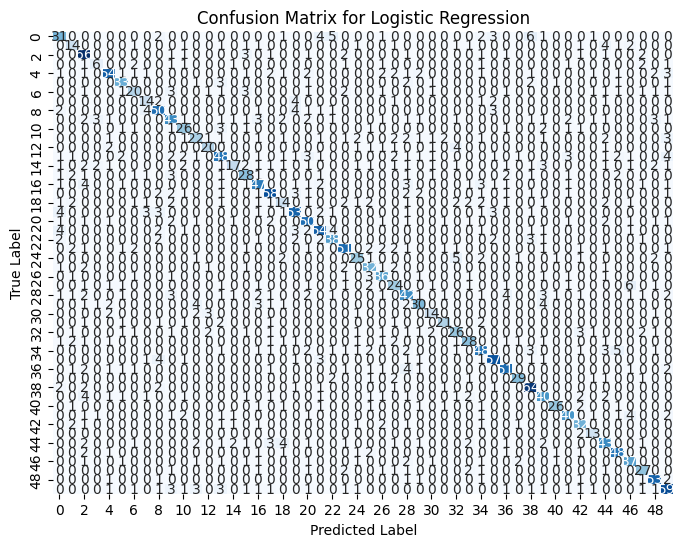

In [ ]:
# Logistic Regression Implementation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)


print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

6. XgBoost

c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6291512915129152

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.42      0.51        57
           1       0.61      0.45      0.52        31
           2       0.76      0.77      0.76        82
           3       0.67      0.32      0.43        19
           4       0.73      0.73      0.73        81
           5       0.80      0.72      0.76        46
           6       0.46      0.43      0.44        42
           7       0.63      0.48      0.55        25
           8       0.58      0.69      0.63        67
           9       0.49      0.53      0.51        75
          10       0.51      0.59      0.55        39
          11       0.68      0.55      0.61        47
          12       0.72      0.66      0.69        32
          13       0.49      0.56      0.53        82
          14       0.69      0.42      0.52        48
          15       0.56      0.50      0.53        48
          16       0.67    

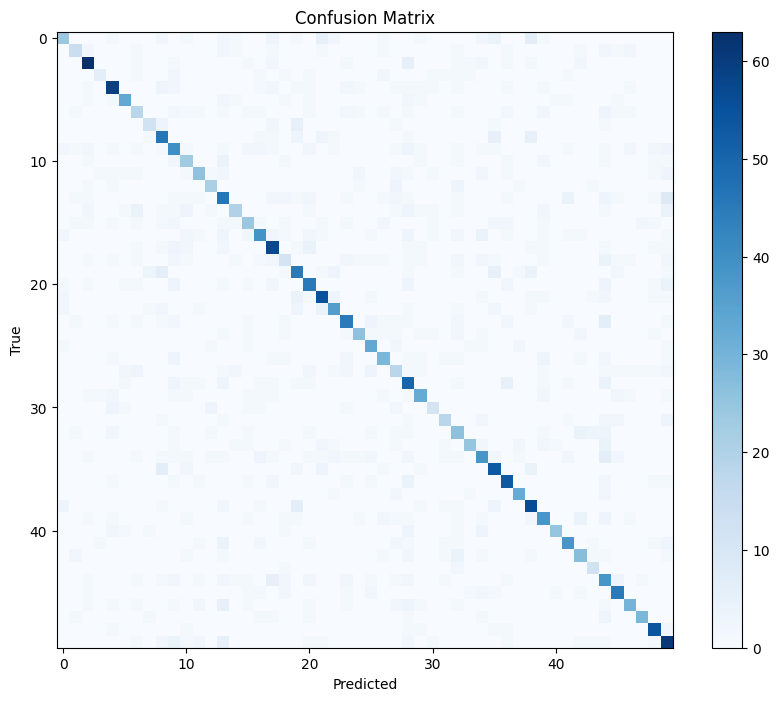

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


# ---- Step 3: XGBoost Classifier ----
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)

model.fit(X_train, y_train)

# ---- Step 4: Evaluation ----
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---- Step 5: Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


K-Means Clustering

In [43]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score, adjusted_rand_score
# from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
# from sklearn.mixture import GaussianMixture
# import numpy as np



# # Try K-Means with optimal settings
# kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10, algorithm='elkan')
# kmeans.fit(X_train)
# cluster_labels = kmeans.predict(X_train)

# # Evaluate with ARI
# ari_score = adjusted_rand_score(y_train, cluster_labels)
# print(f"K-Means (with PCA) ARI: {ari_score:.4f}")

# # Test DBSCAN and GMM
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan_labels = dbscan.fit_predict(X_train)
# dbscan_ari = adjusted_rand_score(y_train, dbscan_labels)
# print(f"DBSCAN ARI: {dbscan_ari:.4f}")

# gmm = GaussianMixture(n_components=num_clusters, random_state=42)
# gmm_labels = gmm.fit_predict(X_train)
# gmm_ari = adjusted_rand_score(y_train, gmm_labels)
# print(f"GMM ARI: {gmm_ari:.4f}")


In [44]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import adjusted_rand_score

# # Number of clusters (should match the number of unique labels in y_train)
# num_clusters = len(set(y_train))

# # Initialize and fit K-means
# kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# kmeans.fit(X_train)

# # Predict cluster labels for the training data
# cluster_labels = kmeans.predict(X_train)

# # Evaluate clustering performance using Adjusted Rand Index (ARI)
# ari_score = adjusted_rand_score(y_train, cluster_labels)
# print(f"Adjusted Rand Index (ARI) for K-means clustering: {ari_score:.4f}")

# # Optional: Visualize the cluster centers
# print("Cluster centers shape:", kmeans.cluster_centers_.shape)

7. ANN :- Artificial Neural Network


In [17]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [19]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in hidden layers
num_classes = len(label_encoder.classes_)  # Number of unique labels

# Initialize the model
model = ANNModel(input_size, hidden_size, num_classes)
#model.load_state_dict(torch.load("saved_models/ann_model.pth"))  # Load the model if needed

# ============================
# 3. Train the Model
# ============================
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500  
batch_size = 32

# Track accuracy
train_accuracies = []
val_accuracies = []
losses = []

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_outputs = model(X_train_tensor)
        train_pred_classes = torch.argmax(train_outputs, axis=1)
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_pred_classes.numpy())
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_outputs = model(X_test_tensor)
        val_pred_classes = torch.argmax(val_outputs, axis=1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred_classes.numpy())
        val_accuracies.append(val_accuracy)
        
        losses.append(loss.item())

    # Print loss and accuracies for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# ============================
# 4. Evaluate the Model
# ============================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1).numpy()
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

# ============================
# 5. Save the Model
# ============================
torch.save(model.state_dict(), "ann_model.pth")
print("Model saved as ann_model.pth")

# ============================
# 6. Plot Training and Validation Accuracy
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Epoch [1/500], Loss: 1.1082, Train Accuracy: 86.40%, Validation Accuracy: 66.68%
Epoch [2/500], Loss: 0.2236, Train Accuracy: 98.35%, Validation Accuracy: 69.96%
Epoch [3/500], Loss: 0.0134, Train Accuracy: 99.82%, Validation Accuracy: 72.14%
Epoch [4/500], Loss: 0.0051, Train Accuracy: 99.94%, Validation Accuracy: 72.21%
Epoch [5/500], Loss: 0.0024, Train Accuracy: 99.96%, Validation Accuracy: 72.25%
Epoch [6/500], Loss: 0.0017, Train Accuracy: 99.99%, Validation Accuracy: 71.99%
Epoch [7/500], Loss: 0.0011, Train Accuracy: 99.99%, Validation Accuracy: 72.07%
Epoch [8/500], Loss: 0.0008, Train Accuracy: 99.99%, Validation Accuracy: 72.36%
Epoch [9/500], Loss: 0.0006, Train Accuracy: 100.00%, Validation Accuracy: 72.10%
Epoch [10/500], Loss: 0.0005, Train Accuracy: 100.00%, Validation Accuracy: 72.25%
Epoch [11/500], Loss: 0.0003, Train Accuracy: 100.00%, Validation Accuracy: 72.29%
Epoch [12/500], Loss: 0.0003, Train Accuracy: 100.00%, Validation Accuracy: 72.25%
Epoch [13/500], Loss:

KeyboardInterrupt: 

In [50]:
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in hidden layers
num_classes = len(label_encoder.classes_)  # Number of unique labels

model = ANNModel(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("saved_models/ann_model.pth"))
model.eval()  # Set the model to evaluation mode

C:\Users\Atanu Kayal\AppData\Local\Temp\ipykernel_4104\1531226835.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/ann_mode

ANNModel(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=50, bias=True)
)

Visualizing the results


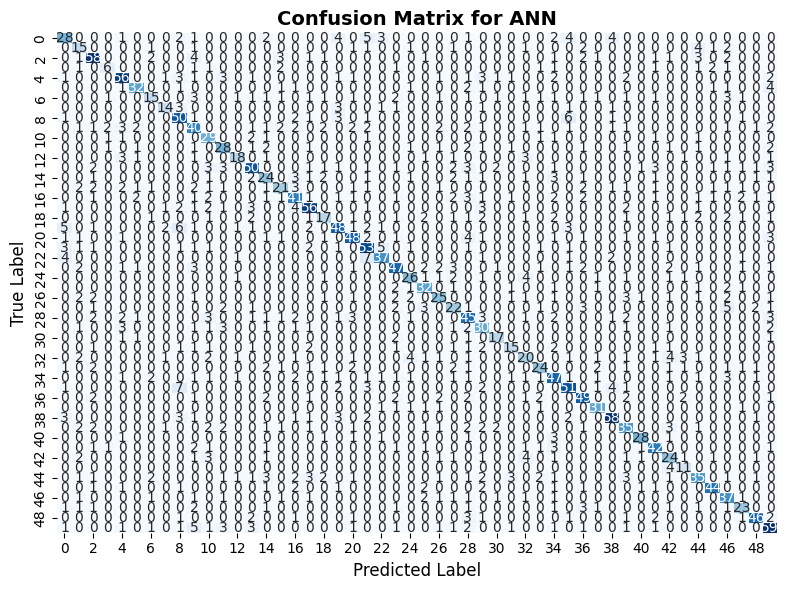

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Generate predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1).numpy()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for ANN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

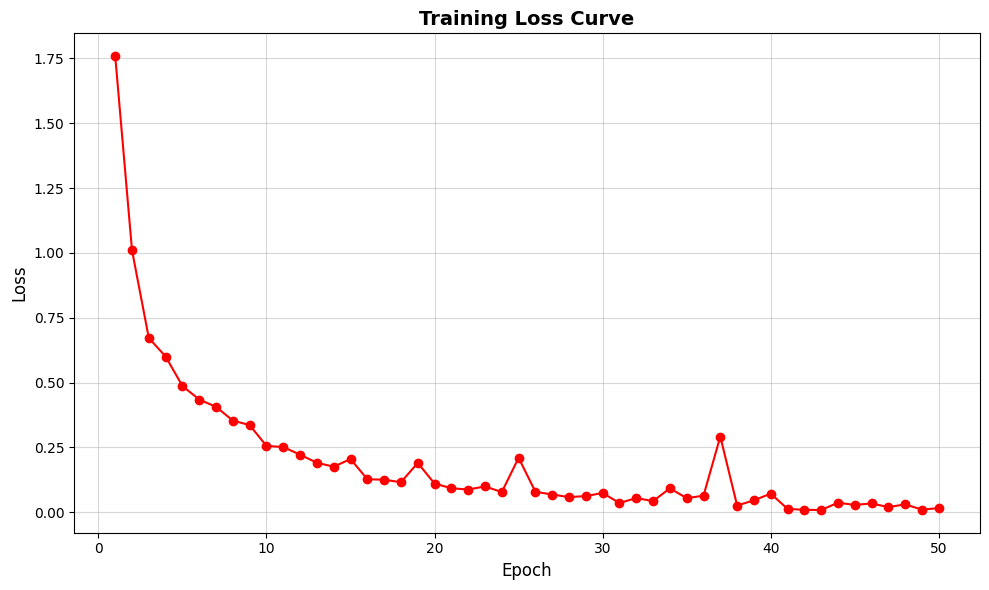

In [56]:
# Assuming `losses` is a list of loss values recorded during training
num_epochs=50
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss', color='red', marker='o')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Mid-Report Plot


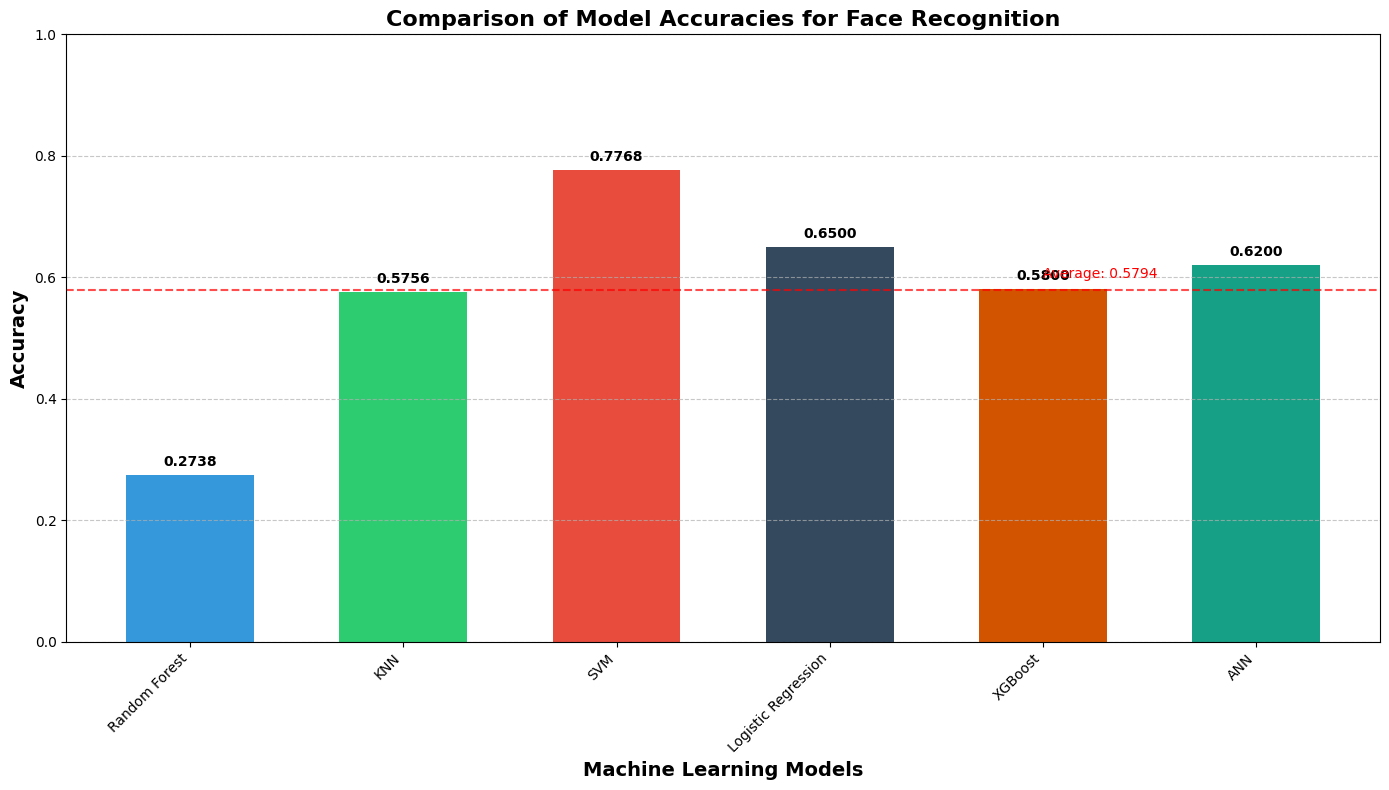

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their accuracies - keeping only SVM with RBF kernel
models = ['Random Forest', 'KNN', 'SVM', 'Logistic Regression', 'XGBoost', 'ANN']
accuracies = [0.2738, 0.5756, 0.7768, 0.65, 0.58, 0.62]

# Create a color palette
colors = ['#3498db', '#2ecc71', '#e74c3c', '#34495e', '#d35400', '#16a085']

# Create the plot
plt.figure(figsize=(14, 8))
bars = plt.bar(models, accuracies, color=colors, width=0.6)

# Add accuracy values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.xlabel('Machine Learning Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Comparison of Model Accuracies for Face Recognition', fontsize=16, fontweight='bold')
plt.ylim(0, 1.0)  # Set y-axis to range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Add a horizontal line for average accuracy
avg_acc = np.mean(accuracies)
plt.axhline(y=avg_acc, color='red', linestyle='--', alpha=0.7)
plt.text(len(models)-2, avg_acc + 0.02, f'Average: {avg_acc:.4f}', color='red')

# Add best model indicator
best_model_idx = np.argmax(accuracies)
best_acc = accuracies[best_model_idx]
plt.text(best_model_idx, best_acc - 0.05, '★ Best Model', ha='center', color='#e74c3c', fontweight='bold')

plt.tight_layout()
plt.show()

8. Naive Bayes

Naive Bayes Accuracy: 0.6214

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        57
           1       0.65      0.55      0.60        31
           2       0.75      0.70      0.72        82
           3       0.14      0.26      0.18        19
           4       0.82      0.65      0.73        81
           5       0.71      0.70      0.70        46
           6       0.39      0.45      0.42        42
           7       0.61      0.56      0.58        25
           8       0.64      0.51      0.57        67
           9       0.46      0.49      0.48        75
          10       0.73      0.77      0.75        39
          11       0.59      0.51      0.55        47
          12       0.65      0.62      0.63        32
          13       0.49      0.57      0.53        82
          14       0.50      0.27      0.35        48
          15       0.57      0.52      0.54        48
          16       0.56     

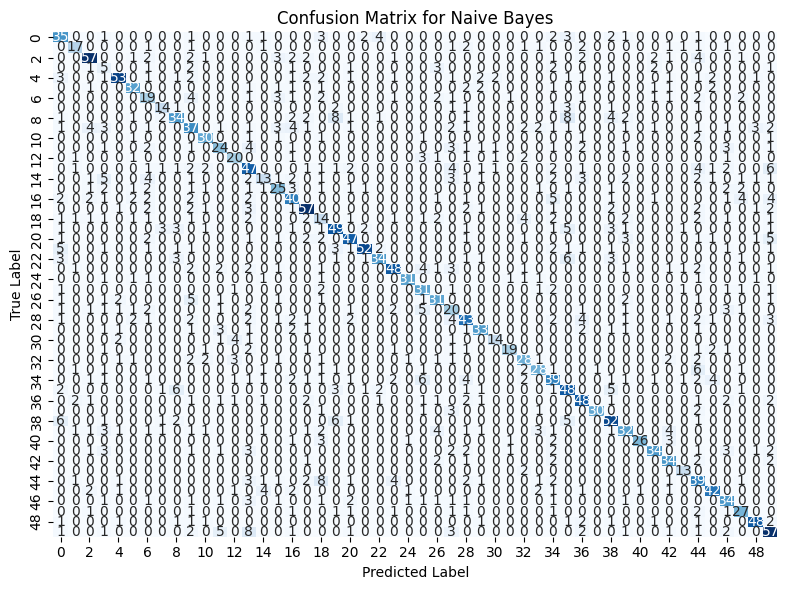

In [57]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Naive Bayes classifier
nb = GaussianNB()

# Train the Naive Bayes model
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes')
plt.tight_layout()
plt.show()

Visualizing the results


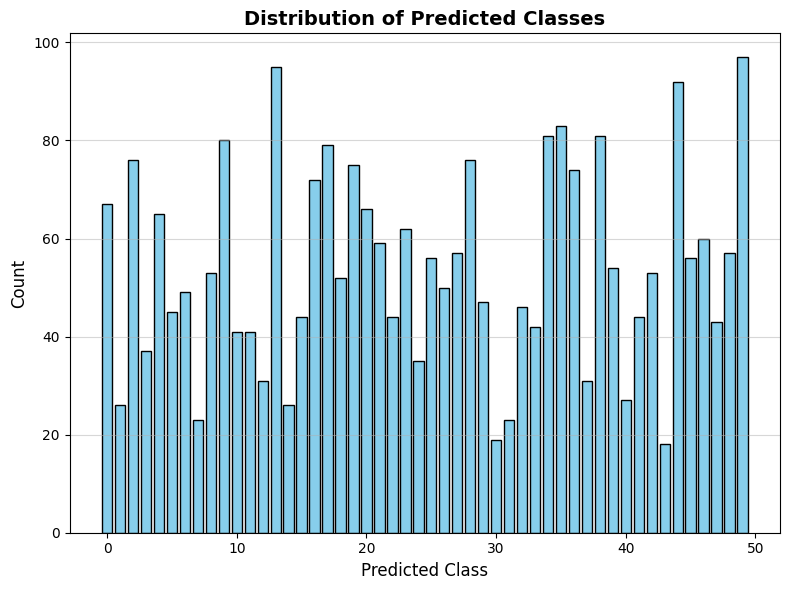

In [59]:
# Count the predicted classes
unique, counts = np.unique(y_pred, return_counts=True)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Predicted Classes", fontsize=14, fontweight="bold")
plt.grid(axis="y", alpha=0.5)
plt.tight_layout()
plt.show()

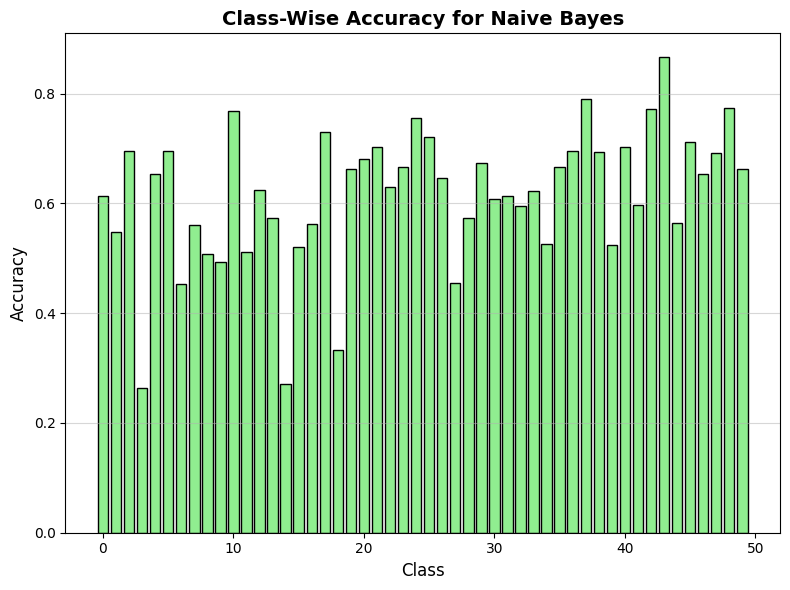

In [58]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate class-wise accuracy
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot class-wise accuracy
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_wise_accuracy)), class_wise_accuracy, color="lightgreen", edgecolor="black")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Class-Wise Accuracy for Naive Bayes", fontsize=14, fontweight="bold")
plt.grid(axis="y", alpha=0.5)
plt.tight_layout()
plt.show()

9. Perceptron


Perceptron Accuracy: 0.4196

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.32        57
           1       0.23      0.23      0.23        31
           2       0.49      0.62      0.55        82
           3       0.14      0.11      0.12        19
           4       0.58      0.56      0.57        81
           5       0.57      0.46      0.51        46
           6       0.16      0.50      0.25        42
           7       0.57      0.48      0.52        25
           8       0.41      0.37      0.39        67
           9       0.35      0.19      0.24        75
          10       0.38      0.38      0.38        39
          11       0.43      0.32      0.37        47
          12       0.38      0.41      0.39        32
          13       0.30      0.54      0.38        82
          14       0.18      0.19      0.18        48
          15       0.36      0.27      0.31        48
          16       0.43      

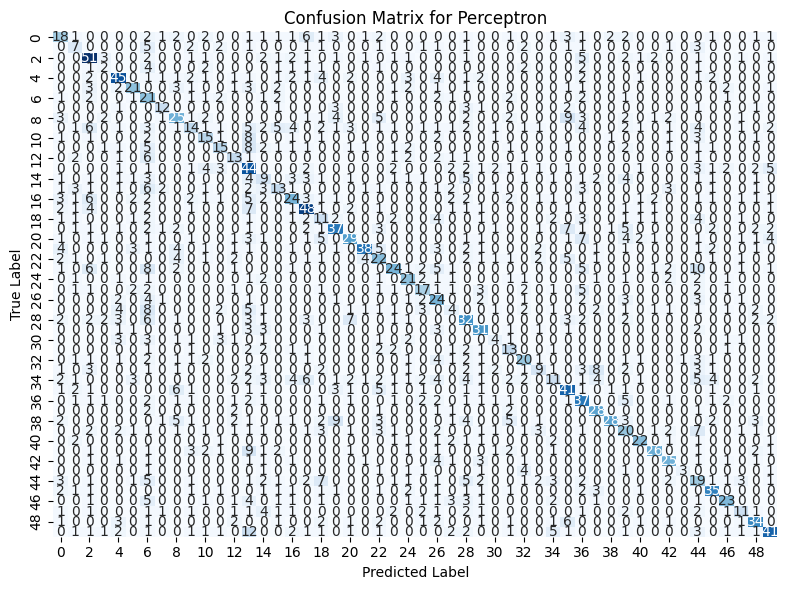

In [60]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Perceptron model
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)

# Train the Perceptron model
perceptron.fit(X_train, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test)

# Calculate accuracy
perceptron_accuracy = accuracy_score(y_test, y_pred)
print(f"Perceptron Accuracy: {perceptron_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Perceptron')
plt.tight_layout()
plt.show()

Ensemble Learning


Voting Ensemble


c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy (Hard Voting): 0.7196

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        57
           1       0.75      0.58      0.65        31
           2       0.74      0.78      0.76        82
           3       0.41      0.37      0.39        19
           4       0.70      0.77      0.73        81
           5       0.82      0.70      0.75        46
           6       0.53      0.55      0.54        42
           7       0.72      0.52      0.60        25
           8       0.71      0.81      0.76        67
           9       0.54      0.61      0.57        75
          10       0.63      0.82      0.71        39
          11       0.74      0.68      0.71        47
          12       0.69      0.69      0.69        32
          13       0.58      0.72      0.64        82
          14       0.91      0.44      0.59        48
          15       0.64      0.67      0.65        48
        

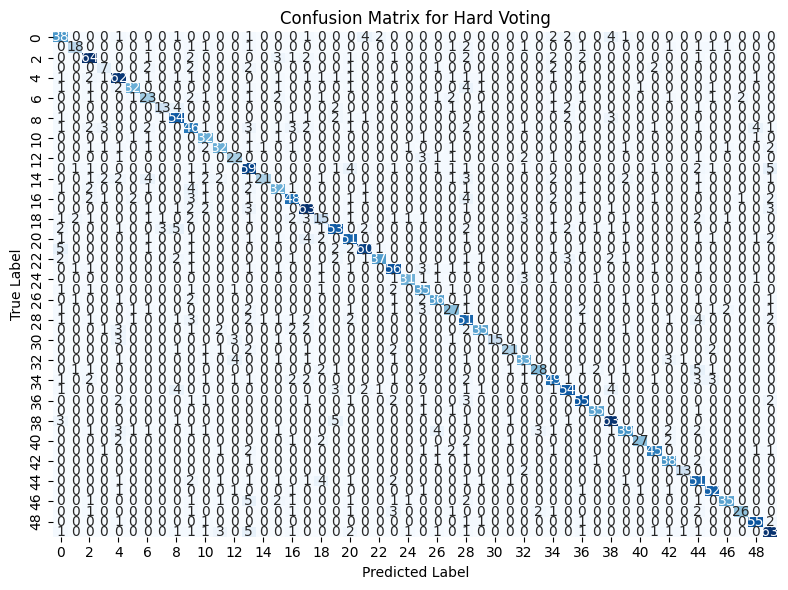

In [63]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Define individual models
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_leaf=2, min_samples_split=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)  # Use `probability=True` for soft voting
knn = KNeighborsClassifier(n_neighbors=12, weights='uniform', metric='euclidean')
lr = LogisticRegression(max_iter=1000, random_state=42)
xgb = XGBClassifier(objective='multi:softprob', num_class=len(set(y_train)), eval_metric='mlogloss', random_state=42)
nb = GaussianNB()
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)

# Define the ANN model (PyTorch-based)
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Load the trained ANN model
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(set(y_train))
ann_model = ANNModel(input_size, hidden_size, num_classes)
ann_model.load_state_dict(torch.load("saved_models/ann_model.pth"))
ann_model.eval()

# Define a wrapper for the ANN model to use it in VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class ANNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # ANN is already trained, so no fitting is needed
        return self

    def predict(self, X):
        with torch.no_grad(): 
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            return torch.argmax(outputs, axis=1).numpy()

# Wrap the ANN model
ann = ANNWrapper(ann_model)

# Create a Voting Classifier (Majority Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('DecisionTree', dt),
        ('RandomForest', rf),
        ('SVM', svm),
        ('KNN', knn),
        ('LogisticRegression', lr),
        ('XGBoost', xgb),
        ('NaiveBayes', nb),
        ('Perceptron', perceptron),
        ('ANN', ann)
    ],
    voting='hard'  # Use 'hard' for majority voting
)

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.4f}")

Boosting

In [64]:
from sklearn.ensemble import AdaBoostClassifier

# Use AdaBoost with Decision Tree as the base estimator
adaboost_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Step size
    random_state=42
)

# Train the AdaBoost model
adaboost_clf.fit(X_train, y_train)

# Evaluate the AdaBoost model
y_pred = adaboost_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Classifier Accuracy: {accuracy:.4f}")

c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classifier Accuracy: 0.2978


Stacking 

In [66]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define base models
base_models = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('SVM', SVC(kernel='rbf', probability=True, random_state=42)),  # Use `probability=True` for stacking
    ('KNN', KNeighborsClassifier(n_neighbors=12, weights='uniform', metric='euclidean')),
    ('NaiveBayes', GaussianNB()),
    ('Perceptron', Perceptron(max_iter=1000, tol=1e-3, random_state=42)),
    ('XGBoost', XGBClassifier(objective='multi:softprob', num_class=len(set(y_train)), eval_metric='mlogloss', random_state=42))    
]

# Define the ANN model (PyTorch-based)
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Load the trained ANN model
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(set(y_train))
ann_model = ANNModel(input_size, hidden_size, num_classes)
ann_model.load_state_dict(torch.load("saved_models/ann_model.pth"))
ann_model.eval()

# Define a wrapper for the ANN model to use it in StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class ANNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # ANN is already trained, so no fitting is needed
        return self

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            return torch.argmax(outputs, axis=1).numpy()

# Wrap the ANN model
ann = ANNWrapper(ann_model)

# Add the ANN model to the base models
base_models.append(('ANN', ann))

# Define the meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,  # Meta-model
    cv=5  # Cross-validation for meta-model training
)

# Train the Stacking model
stacking_clf.fit(X_train, y_train)

# Evaluate the Stacking model
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {accuracy:.4f}")

C:\Users\Atanu Kayal\AppData\Local\Temp\ipykernel_4104\3074205144.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_model.load_state_dict(torch.load("saved_models/ann

Stacking Classifier Accuracy: 0.4576


Testing (Using SVM)


In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_pretrained_model().to(device)  # Move model to the correct device

c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


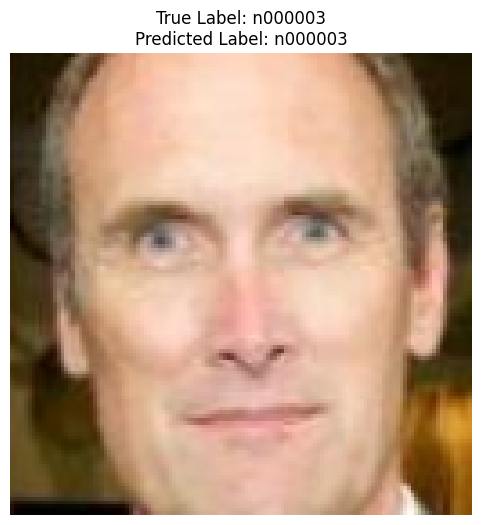

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to preprocess a single image (e.g., feature extraction, scaling, PCA)
def preprocess_image(image, scaler, pca):
    """
    Preprocess a single image by extracting features, scaling, and applying PCA.

    Parameters:
    - image: Input image (e.g., NumPy array of shape (128, 128, 3)).
    - scaler: Fitted StandardScaler object.
    - pca: Fitted PCA object.

    Returns:
    - preprocessed_image: Preprocessed feature vector.
    """
    # Extract features (HOG, LBP, CNN)
    hog_feat = extract_hog_features(image)
    lbp_feat = extract_lbp_features(image)
    cnn_feat = extract_cnn_features(image, model, device)
    
    # Combine features
    combined_features = np.concatenate([cnn_feat, hog_feat, lbp_feat])
    combined_features = combined_features.reshape(1, -1)  # Reshape for scaling
   
    
    #  Apply PCA
    reduced_features = pca.transform(combined_features)
    
    # Scale features
    preprocessed_image = scaler.transform(reduced_features)
    
    
    return preprocessed_image

# Function to predict and display the result
def predict_and_display(image, true_label, scaler, pca, svm, label_encoder):
    """
    Predict the label of a single image using the trained SVM model and display the result.

    Parameters:
    - image: Input image (e.g., NumPy array of shape (128, 128, 3)).
    - true_label: True label of the image.
    - scaler: Fitted StandardScaler object.
    - pca: Fitted PCA object.
    - svm: Trained SVM model.
    - label_encoder: Fitted LabelEncoder object.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image, scaler, pca)
    
    # Predict the label
    predicted_label_encoded = svm.predict(preprocessed_image)
    predicted_label = label_encoder.inverse_transform(predicted_label_encoded)
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label[0]}")
    plt.axis('off')
    plt.show()

# Example usage
# Assuming `images`, `labels`, `scaler`, `pca`, `svm`, and `label_encoder` are already defined
sample_index = 249 # Index of the sample image to predict
sample_image = images[sample_index]
sample_true_label = labels[sample_index]

predict_and_display(sample_image, sample_true_label, scaler, pca, svm, label_encoder)

First correct prediction found at index 249:
True Label: n000003
Predicted Label: n000003


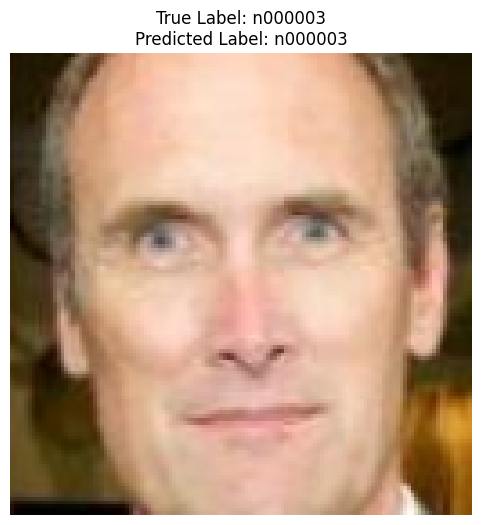

In [115]:
# Function to find the first correctly predicted image
def find_first_correct_prediction(images, labels, scaler, pca, svm, label_encoder):
    """
    Find the first image that is predicted correctly by the trained SVM model.

    Parameters:
    - images: List of images (e.g., NumPy arrays of shape (128, 128, 3)).
    - labels: List of true labels corresponding to the images.
    - scaler: Fitted StandardScaler object.
    - pca: Fitted PCA object.
    - svm: Trained SVM model.
    - label_encoder: Fitted LabelEncoder object.

    Returns:
    - index: Index of the first correctly predicted image.
    - true_label: True label of the image.
    - predicted_label: Predicted label of the image.
    """
    for index, (image, true_label) in enumerate(zip(images, labels)):
        # Preprocess the image
        preprocessed_image = preprocess_image(image, scaler, pca)

        # Predict the label
        predicted_label_encoded = svm.predict(preprocessed_image)
        predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

        # Check if the prediction is correct
        if predicted_label[0] == true_label:
            return index, true_label, predicted_label[0]

    return None, None, None  # If no correct prediction is found

# Example usage
index, true_label, predicted_label = find_first_correct_prediction(images, labels, scaler, pca, svm, label_encoder)

if index is not None:
    print(f"First correct prediction found at index {index}:")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

    # Display the correctly predicted image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()
else:
    print("No correct predictions found.")